In [ ]:
# Colab setup

# from google.colab import drive
# drive.mount("/content/drive/")

# %cd "/content/drive/MyDrive/PACS/APSC_project/bayesian_network/examples/1_darcy_flow"

# try:
#     from dlroms import *
# except:
#     !pip install git+https://github.com/NicolaRFranco/dlroms.git
#     from dlroms import *

In [1]:
from dlroms import *
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from IPython.display import clear_output as clc

In [2]:
domain = fe.rectangle((0.0, 0.0), (1.0, 1.0)) # - fe.rectangle((0.3, 0.3), (0.7, 0.7))
mesh = fe.mesh(domain, stepsize=0.05)
clc()

In [3]:
# Load train and test data

snapshots_dir = os.path.join(os.getcwd(), "snapshots")

n_samples = 1000

K_data = np.load(os.path.join(snapshots_dir, "K_" + str(n_samples) + ".npy"))
p_data = np.load(os.path.join(snapshots_dir, "p_" + str(n_samples) + ".npy"))
u_x_data = np.load(os.path.join(snapshots_dir, "u_x_" + str(n_samples) + ".npy"))
u_y_data = np.load(os.path.join(snapshots_dir, "u_y_" + str(n_samples) + ".npy"))

N_train = int(0.8 * n_samples)
N_test = n_samples - N_train

K_train = torch.tensor(K_data[:N_train], dtype=torch.float)
p_train = torch.tensor(p_data[:N_train], dtype=torch.float)
u_x_train = torch.tensor(u_x_data[:N_train], dtype=torch.float)
u_y_train = torch.tensor(u_y_data[:N_train], dtype=torch.float)

K_test = torch.tensor(K_data[N_train:], dtype=torch.float)
p_test = torch.tensor(p_data[N_train:], dtype=torch.float)
u_x_test = torch.tensor(u_x_data[N_train:], dtype=torch.float)
u_y_test = torch.tensor(u_y_data[N_train:], dtype=torch.float)

## Deterministic network

In [86]:
# Train network for pressure

V = fe.space(mesh, 'CG', 1)

layer = Local(V, V, support=0.1)

p_model = DFNN(layer, layer, layer)
p_model.He()

p_model.train(K_train, p_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=100, loss=mse(euclidean), verbose=True)

		Train		Valid		Test
Epoch 19:	1.09e-01	2.47e-01	nan.

>> ETA: 5m 13.70s.

Training complete. Elapsed time: 1 minutes 12.92 seconds.


In [ ]:
# layer = Local(V, V, support=0.1), 2 layers, 100 epochs: 1.82e-01 train, 2.09e-01 valid (early stopping)
# layer = Local(V, V, support=0.2), 2 layers, 100 epochs: 8.71e-02 train, 1.33e-01 valid (early stopping)
# layer = Local(V, V, support=0.3), 2 layers, 100 epochs: 6.96e-02 train, 1.29e-01 valid (early stopping) <--
# layer = Local(V, V, support=0.1), 3 layers, 100 epochs: 1.59e-01 train, 2.18e-01 valid (early stopping)
# layer = Local(V, V, support=0.2), 3 layers, 100 epochs: 7.03e-02 train, 1.50e-01 valid (early stopping)
# layer = Local(V, V, support=0.3), 3 layers, 100 epochs: 6.01e-02 train, 1.31e-01 valid (early stopping)

In [87]:
# Generate predictions

p_model.eval()

with torch.no_grad():
  p_pred = p_model(K_test)

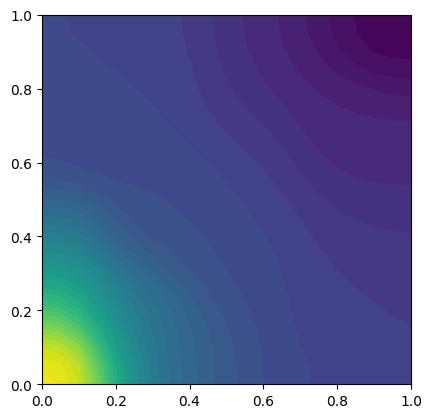

In [88]:
idx = 90
p_fun = Function(V)
p_fun.vector()[:] = p_test[idx]
plot(p_fun)

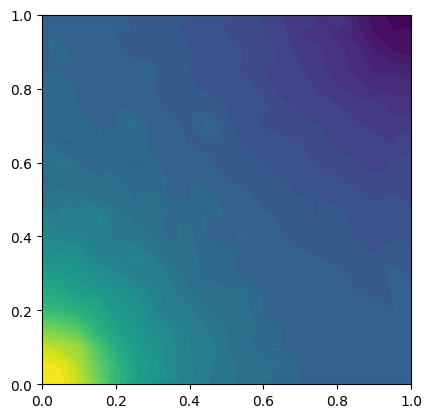

In [89]:
p_fun_pred = Function(V)
p_fun_pred.vector()[:] = p_pred[idx]
plot(p_fun_pred)

In [78]:
# Train network for velocity

V = fe.space(mesh, 'CG', 1)

layer = Local(V, V, support=0.3)

v_model = DFNN(layer, layer, layer)
v_model.He()

v_model.train(K_train, u_x_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=100, loss=mse(euclidean), verbose=True)

		Train		Valid		Test
Epoch 16:	2.43e-01	7.56e-01	nan.

>> ETA: 2m 14.24s.

Training complete. Elapsed time: 25.53 seconds.


In [ ]:
# layer = Local(V, V, support=0.1), 2 layers, 100 epochs: 7.29e-01 train, 8.81e-01 valid (early stopping)
# layer = Local(V, V, support=0.2), 2 layers, 100 epochs: 3.37e-01 train, 5.90e-01 valid (early stopping) <--
# layer = Local(V, V, support=0.3), 2 layers, 100 epochs: 2.37e-01 train, 6.23e-01 valid (early stopping)
# layer = Local(V, V, support=0.1), 3 layers, 100 epochs: 5.50e-01 train, 7.32e-01 valid (early stopping)
# layer = Local(V, V, support=0.2), 3 layers, 100 epochs: 2.76e-01 train, 6.29e-01 valid (early stopping)
# layer = Local(V, V, support=0.3), 3 layers, 100 epochs: 2.43e-01 train, 7.56e-01 valid (early stopping)

In [79]:
# Generate predictions

v_model.eval()

with torch.no_grad():
  u_x_pred = v_model(K_test)

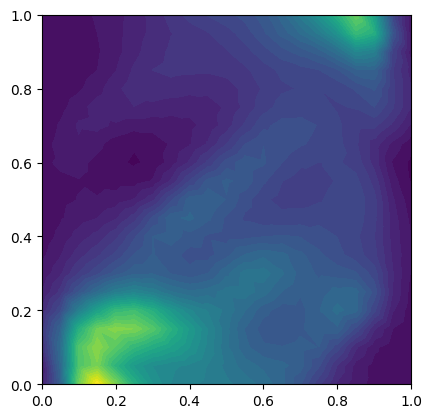

In [80]:
idx = 90
u_x_fun = Function(V)
u_x_fun.vector()[:] = u_x_test[idx]
plot(u_x_fun)

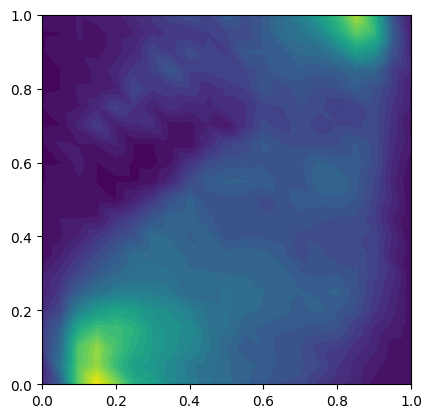

In [81]:
u_x_fun_pred = Function(V)
u_x_fun_pred.vector()[:] = u_x_pred[idx]
plot(u_x_fun_pred)

- Spazi funzionali? (layer da spazio fine a coarse o viceversa)
- Numero di layer?
- Supporto?
- Perché rete sparsa? (source localizzata in spazio)
- Vantaggio rispetto a rete densa? (comparable accuracy with fewer weights)
- Come quantificare errore? (pointwise difference)
- Mesh per definizione dataset? (size, euclidean vs geodesic)
- Loss? (adversarial loss, physics-informed)
- KLE?
- Parallelization?

## Bayesian network

In [4]:
# Bayesian network for pressure

import sys
sys.path.append(os.path.join("..", "..", "dlroms"))
from bayesian import *

V = fe.space(mesh, 'CG', 1)

layer_1 = Local(V, V, support=0.3)
layer_2 = Local(V, V, support=0.3)
layer_3 = Local(V, V, support=0.3)

p_model = DFNN(layer_1, layer_2, layer_3)

p_bayes = Bayesian(p_model)
p_bayes.He() # set prior on weights

In [5]:
p_svgd = SVGD(p_bayes, lr=1e-3)

In [ ]:
p_svgd.train(K_train, p_train, ntrain=int(0.8*N_train), loss=mse(euclidean), epochs=200)

In [120]:
# p_pred_bayes = bayes(p_test)
# print(p_pred_bayes.shape) # torch.Size([20, 200, 441])

In [7]:
p_pred_bayes_mean, p_pred_bayes_var = p_bayes.predict(p_test)

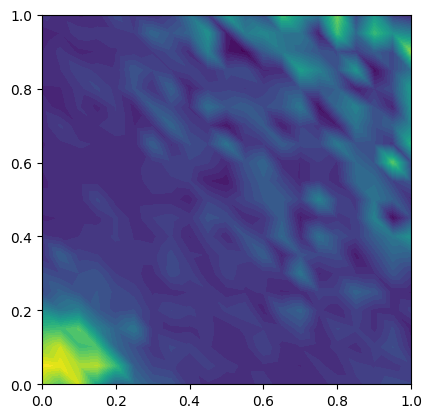

In [8]:
idx = 90
p_fun_pred_bayes_mean = Function(V)
p_fun_pred_bayes_mean.vector()[:] = p_pred_bayes_mean[idx].detach().numpy()
plot(p_fun_pred_bayes_mean)

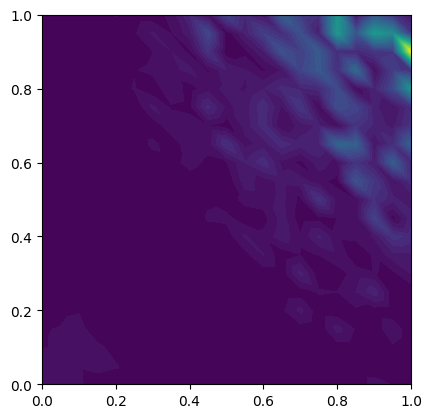

In [9]:
p_fun_pred_bayes_var = Function(V)
p_fun_pred_bayes_var.vector()[:] = p_pred_bayes_var[idx].detach().numpy()
plot(p_fun_pred_bayes_var)

In [ ]:
# Bayesian network for velocity

layer_1 = Local(V, V, support=0.3)
layer_2 = Local(V, V, support=0.3)
layer_3 = Local(V, V, support=0.3)

v_model = DFNN(layer_1, layer_2, layer_3)

v_bayes = Bayesian(v_model)
v_bayes.He() # set prior on weights

In [12]:
v_svgd = SVGD(v_bayes, lr=1e-4)

In [13]:
v_svgd.train(K_train, u_x_train, ntrain=int(0.8*N_train), epochs=50)

Epoch: 50/50, RMSE: 0.094821, RMSE test: 0.092773: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


In [14]:
u_x_pred_bayes_mean, u_x_pred_bayes_var = v_bayes.predict(u_x_test)

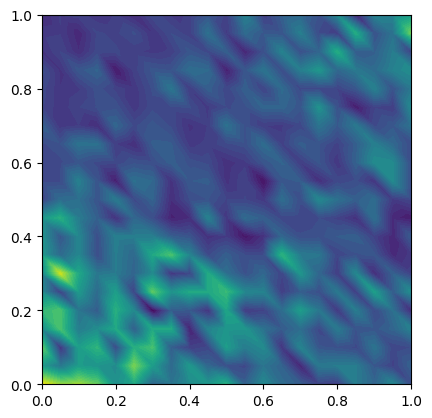

In [15]:
u_x_fun_pred_bayes_mean = Function(V)
u_x_fun_pred_bayes_mean.vector()[:] = u_x_pred_bayes_mean[idx].detach().numpy()
plot(u_x_fun_pred_bayes_mean)

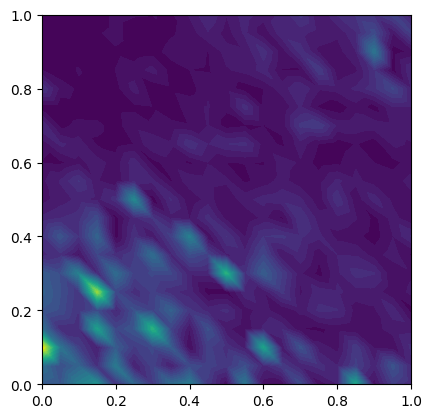

In [26]:
u_x_fun_pred_bayes_var = Function(V)
u_x_fun_pred_bayes_var.vector()[:] = u_x_pred_bayes_var[idx].detach().numpy()
plot(u_x_fun_pred_bayes_var)

- Tradeoff memory vs execution time (is mesh-informed prior "sparse enough" to enable vectorized implementation? which are the limits?)
- torch.jit to make basic operation (e.g. matmul) faster
- Input as tuple (like in ROM)
- Verbose, ETA, etc. (like in ROM)
- Choice of optimizer and scheduler
- Choice of prior?